# Machine Learning

Dieses Notebook beinhaltet die Prüfungsleistung für Machine Learning bei Frau Minges. Es wurde erstellt von Patrick Mischka, Jan Grübener, Matthias Vonend, Aaron Schweig, Michael Angermeier und Troy Keßler.

## Inhalt

Ziel ist hier mithilfe von Machine Learning eine Trading Recommendation für Ethereum zu entwickeln. Diese soll aus zwei Teilen bestehen, einmal aus einer technischen Analyse, wo ein LSTM Modell mithilfe historischen Preise und Indikatoren entwickelt und trainiert wird, und einmal aus einer Stimmunsanalyse auf Twitter, wofür ein weiteres Deep Neural Network entwickelt und trainiert wird. Letztendlich sollen die Ergebnisse dieser Modelle Entscheidungshilfen sein, um Ethereum zu handeln.

### 1. Sentimentmodell

Im ersten Teil wird ein Sentimentmodell entwickelt und trainiert, das Ziel ist hier ein Modell zu entwickelt, welches Tweets auf ihre Stimmung bewerten kann.

### 2. Technisches Modell

Im zweiten Teil wird ein technisches Modell entwickelt und trainiert, das Ziel ist hier basierend auf historischen Preisen und anderen technischen Indikatoren den zukünftigen Preis für die nächsten 30 Tage vorherzusagen.

### 3. Ausführung

Im dritten und letzten Teil werden die Modelle an APIs angeschlossen, sodass die Entscheidungshilfen live ausgeführt werden können.

## Technologien

Für das Modell wird [Tensorflow](https://www.tensorflow.org/) verwendet, zum plotten von Informationen nutzen wir [Matplotlib](https://matplotlib.org/stable/index.html) und zum verarbeiten von Daten [Pandas](https://pandas.pydata.org/). Weiterhin werden weitere utilities von [sklearn](https://scikit-learn.org/stable/) übernommen.

## Setup

Um dieses Notebook zu benutzen müssen Python 3.x und folgende Packages installiert werden:

* tensorflow
* matplotlib
* pandas
* sklearn

Das Datenset fürs trainieren kann über [diesen Link](https://www.dropbox.com/s/ur7pw797mgcc1wr/tweets.csv?dl=0) heruntergeladen werden. Dabei muss die Datei "tweets.csv" in diesen Ordner abgelegt werden.


## 1. Sentimentmodell

In diesem Notebook wird ein Modell trainiert, welches Tweets live auf ihre Stimmung bewerten soll. Dafür wird ein Deep Neural Network erstellt, welches mit 1.6 Millionen Tweets trainiert wird. Hierbei handelt es sich um ein Klassifikationsproblem, es soll letztendlich entschieden werden, ob ein Tweet negativ (0), oder positiv (1) gestimmt ist.

### Datenset

Um nun das Modell möglichst gut darauf zu trainieren reale Tweets zu bewerten haben wir uns für ein Datenset entschieden, welches 1.6 Millionen bereits gelabelte Tweets enthält, dieses kann [hier](https://www.kaggle.com/kazanova/sentiment140) gefunden werden

In [7]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import feature_column

### Laden des Datensets

Mithilfe von pandas wird das Datenset geladen, dabei werden nur die erste und die letzte Spalte geladen, da nur diese für uns von Interesse sind. Da es sich bei der ersten Spalte um die Stimmung des Tweets handelt wird diese mit "targets" gelabelt, die letzte Spalte beihaltet den eigentlichen Tweet, diese wird mit "text" gelabelt.

In [2]:
dataframe = pd.read_csv("./tweets.csv", usecols=[0, 5], names=["target", "text"])

Da das Datenset sortiert ist muss es randomisiert werden. Falls dies nicht gemacht werden würde, hätte dies einen negativen Einfluss auf das Lernen, da alle Daten die zuerst reinkommen negativ gelabelt sind. Somit würde das Modell denken, alles wäre negativ und würde sich entsprechend darauf einstellen, kommen dann letztendlich alle positiven Daten würde das Modell denken es gäbe nur positive Daten und würde letztendlich bei richtigen Daten immer eine positive Stimmung predicten, was nicht der Realtität entsprechen würde.

In [3]:
dataframe = shuffle(dataframe)

Zum validieren, dass das Datenset auch korrekt geladen wurde, es sollte eine Tabelle mit den ersten fünf Einträgen zu sehen sein

In [4]:
dataframe.head()

,target,text
1393055,4,@vnesnz link link clickidy click click xx (via...
73173,0,Uuuugh. Just got to hotel and have to get up i...
1325450,4,"Sure, rub in the fact that you have made it to..."
334535,0,I seriously can't wait until i move out. Whene...
1538908,4,@pelagiapais Enjoy your evening X


Um das trainieren des Modells zu überwachen und um die Accuracy des Modells hinterher zu errechnen wird das Datenset in drei Teile unterteilt. In einem Verhältnis von 80:20 wird das Datenset in Trainingsdaten und Testdaten unterteilt. Trainingsdaten dienen hier ausschließlich zum trainieren des Modells, Testdaten werden nach dem Trainieren dazu verwendet, um die Accuracy des Modells zu errechnen, diese sollen reale Daten simulieren. Der Grund, warum das Verhältnis stark auf der Seite der Trainingsdaten liegt, ist, weil mehr Trainingsdaten ein besseres Ergebnis versprechen, dabei muss die Anzahl der Daten bei den Testdaten nicht hoch sein, um die Accuracy zu bestimmen.

Weiterhin werden die Trainingsdaten wiederum in Trainingsdaten und Validationsdaten mit einem Verhältnis von 80:20 unterteilt. Die Validationsdaten werden dazu verwendet um das Training zu überwachen, nach jedem Epoch (Trainingsschritt) wird damit die aktuelle Accuracy bestimmt.

In [5]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train), 'training tweets')
print(len(val), 'validation tweets')
print(len(test), 'test tweets')

1024000 training tweets
256000 validation tweets
320000 test tweets


Da jetzt das Datenset entsprechend aufgeteilt wurde kann es nun in das verlangte Tensorflowformat gebracht werden. Dafür werden die Features (text) und die Labels (labels) klar definiert. Zusätzlich wird eine Batchsize definiert, welche Daten gruppiert um das Lernen zu beschleunigen.

In [6]:
def df_to_dataset(dataframe, batch_size):
  dataframe = dataframe.copy()
  texts = dataframe.pop('text')
  labels = dataframe.pop('target')
  return tf.data.Dataset.from_tensor_slices((texts, labels)).batch(batch_size)

In [7]:
batch_size = 320

raw_train_ds = df_to_dataset(train, batch_size)
raw_val_ds = df_to_dataset(val, batch_size)
raw_test_ds = df_to_dataset(test, batch_size)

Um zu validieren, dass die Konvertierung geklappt hat werden die ersten drei Einträge ausgelesen

In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Tweet:", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Tweet: b"@britkoz sorry I'm not gone b able to make it  I'm having a &quot;KickBack&quot; at my spot tonite.yo ppl stopping through.. so ill give u a present"
Label: 0
Tweet: b'@souleyedee the first weekend we might be able to go to the beach and ur leaving me  *sigh* I must be hardcore w/out u'
Label: 0
Tweet: b'Hi new followers '
Label: 4


Hier werden die Daten für das Modell normalisiert. Dies ist wichtig um unnötige Duplikate zu vermeiden, wie z.B. Wörter, die in manchen Tweets groß und in anderen wieder klein geschrieben werden. Zusätzlich können Usernames, welche mit "@" beginnen normalisiert werden, da der genaue username unwichtig für die sentiment prediction ist.

In [9]:
def normalize_data(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase, '@(\w*)|(\\n)|(https:\/\/t\.co[\w\/]*)', '')

Nun können die Texte vektorisiert werden. Da ein neuronales Netz nicht mir Wörtern und Buchstaben arbeiten kann, müssen diese in Zahlen umgewandelt werden. Dafür werden die Tweets in Vektoren umgewandelt. Die Größe des Vektors wird dabei mit sequence_length definiert. Die Größe der sequence_length, also letztendlich die Größe des Vektors sollte in der Regel so groß sein, dass alle Wörter eines Tweets hereinpassen. Da die Anzahl an Zeichen auf 280 pro Tweet limitiert ist, und die durschnittliche Anzahl der Zeichen pro Wort im Englischen bei 5 liegt wird die sequence_length mit 56 definiert.

Hier erhält jedes Wort eine fortlaufende Id, die Reihenfolge wird darüber bestimmt, welche Wörter zuerst vektorisiert werden. Dabei können aufgrund max_features maximal 10000 Wörter eingelesen werden, alle weiteren werden ignoriert, diese Menge an Vokabeln sollte aber ausreichen, da in der Alltagssprache lediglich zwei bis drei tausend Wörter verwendet werden. Somit kann jedes Wort zu einer Id gemappt werden, sodass man letztendlich ganze Sätze in einem Vektor abbilden kann. Damit lösen wir auch das Problem, dass ein neuronales Netz immer die gleiche Inputgröße benötigt, da die Vektorengröße immer der sequence_length enstpricht.

Dafür wird hier ein Vektorlayer erstellt. Gleichzeitig können hier die Daten normalisiert werden.

In [10]:
max_features = 10000
sequence_length = 56

vectorize_layer = TextVectorization(
    standardize=normalize_data,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Hier werden die Trainingsdaten eingelesen, sodass die 10000 features gefüllt werden können, somit haben wir für die Tweets ein eigenes "Wörterbuch"

In [11]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Mit der Methode können wir gleich alle Datensets vektorisieren. Hier normalisieren wir noch das Label, sodass das Label eine Range von 0 bis 1, anstatt von 0 bis 4 hat. 

In [12]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), int(label / 4)

Um zu testen, ob das vektorisieren der Tweets funktioniert können wir den ersten Tweet aus dem ersten Batch auslesen und vektorisieren.

In [13]:
text_batch, label_batch = next(iter(raw_train_ds))
text, label = text_batch[0], label_batch[0]
print(text)
print(label)
print(vectorize_text(text, label))

tf.Tensor(b"@britkoz sorry I'm not gone b able to make it  I'm having a &quot;KickBack&quot; at my spot tonite.yo ppl stopping through.. so ill give u a present", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
(<tf.Tensor: shape=(1, 56), dtype=int64, numpy=
array([[ 130,   19,   25,  384,  547,  432,    3,  111,   12,   19,  160,
           5,    1,   24,    6, 1921,    1,  688, 4303,    1,   15,  395,
         294,   55,    5, 2129,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]])>, 0)


Mithilfe des Vektorlayers können wir die Ids wieder zu Wörtern zurückmappen, außerdem können wir die Größe unseres Wörterbuchs auslesen

In [14]:
print("1234 ---> ", vectorize_layer.get_vocabulary()[1234])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1234 --->  drop
Vocabulary size: 10000


Nun vektorisieren wir alle benötigten Datensets

In [15]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Aus Performancegründen können die Datensets weiter aufbereitet werden. Mit `.cache()` bleiben die Daten im Arbeitsspeicher, nachdem diese von der Festplatte geladen wurden. Somit kann sichergestellt werden, dass das Laden der Daten nicht das Bottleneck beim Training sein wird.

Mit `.prefetch()` können die Daten gleichzeitig mit dem Lernen präprozessiert werden.

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Schließlich definieren wir das eigentliche Modell. Die erste Layer ist ein Embedding-Layer. Dies sorgt dafür, dass jedes Wort wiederum einen eigenen Vektor erhält, dieser stellt die Bedeutung des Wortes dar. Diese Vektoren werden mit dem Modell mit der Zeit trainiert. Diese Embeddinglayer fügt eine weitere Dimension zum Outputvektor hinzu. Hier definieren wir mit der embedding_dim die Größe der Layers, das bedeutet, dass es 32 Nodes pro Layer gibt.

Für die nächste Layer wird `GlobalAveragePooling1D` verwendet. Diese reduziert die Dimension wieder um 1 und verrechnet dabei alle Informationen, sodass nichts verloren geht. Der Outputvektor wird dabei wieder auf eine feste Länge normalisiert.

Anschließend folgt ein fully-connected 32 Dense-Layer. Hier wurde eine Dropoutrate festgelegt, um Overfitting zu verhindern. Das Ziel hier ist random ausgewählte Nodes auf 0 zu setzen, damit das anspassen der Weights der einzelnen Nodes beim lernen gefördert wird.

Letztendlich wird das letzte Layer mit einem Dense Layer zu einer einzigen Node verknüpft. Diese hat eine Range von 0 bis 1 und gibt das Ergenis aus.

Wir können nun noch mit `.summary()` das Modell verifizieren.

In [17]:
embedding_dim = 32

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320032    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 320,065
Trainable params: 320,065
Non-trainable params: 0
_________________________________________________________________


Für das Trainieren müssen noch ein paar Parameter definiert werden. Für die Berechnung des Fehlers (loss) verwenden wir die `BinaryCrossentropy` Funktion. Der Fehler gibt uns an, wie weit wir von der richtigen Prediction weg sind. Wir haben uns dafür entschieden, da wir einen sogenannten Binary Classifier haben, der uns eine Wahrscheinlichkeit von 0 bis 1 als Ergebnis gibt. Dabei arbeiten wir mit Logits, sodass die Labels als sogennante Logits betrachtet werden, diese Darstellung als Wahrscheinlichkeit verspricht laut Tensorflow größere numerische Stabilität.

Weiterhin verwenden wir für den Optimierungsalgorithmus den `Adam-Optimizer`. Wir haben uns für den Adam-Optimizer, im Gegensatz zum klassischen Stochastic Gradient Descent Algorithmus entschieden, da sich die Learningrate beim Adam-Optimizer mit der Zeit automatisch anpasst. Das ist besonders praktisch bei Natural Language Processing, da hier die Gradients in der Regel sehr gering sind. Dabei wird die Learningrate basierend auf der vorherigen Änderung der Weights angepasst. Hier haben wir eine sehr kleine Learningrate definiert, da wir ein sehr großes Datenset haben und nicht zu schnell in das Problem von Overfitting laufen wollen, weshalb langsameres lernen, also ein langsameres Anpassen der Weights, hier passender ist.

In [18]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

Nun wird endlich das Modell trainiert. Dafür definieren wir mit epochs, wie oft wir über das Trainingsdatenset iterieren. Es werden in `model.fit()` die Trainingsdaten, die Validationsdaten und die Anzahl der Epochen angegeben. Tensorflow loggt den Fortschritt live in der Konsole aus, zusätzlich wird der Trainingsstatus in einem History-Objekt festgehalten.

In [19]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
3200/3200 [==============================] - 10s 3ms/step - loss: 0.6863 - binary_accuracy: 0.5963 - val_loss: 0.6528 - val_binary_accuracy: 0.6864
Epoch 2/10
3200/3200 [==============================] - 8s 2ms/step - loss: 0.6393 - binary_accuracy: 0.6962 - val_loss: 0.6000 - val_binary_accuracy: 0.7175
Epoch 3/10
3200/3200 [==============================] - 8s 2ms/step - loss: 0.5902 - binary_accuracy: 0.7243 - val_loss: 0.5610 - val_binary_accuracy: 0.7406
Epoch 4/10
3200/3200 [==============================] - 8s 2ms/step - loss: 0.5544 - binary_accuracy: 0.7454 - val_loss: 0.5328 - val_binary_accuracy: 0.7560
Epoch 5/10
3200/3200 [==============================] - 8s 3ms/step - loss: 0.5285 - binary_accuracy: 0.7593 - val_loss: 0.5131 - val_binary_accuracy: 0.7665
Epoch 6/10
3200/3200 [==============================] - 8s 2ms/step - loss: 0.5106 - binary_accuracy: 0.7683 - val_loss: 0.4998 - val_binary_accuracy: 0.7732
Epoch 7/10
3200/3200 [=============================

Nachdem das Modell nur trainiert ist können wir es mit den vorher festgelegten Testdatensatz testen. Diese sollen wie bereits erwähnt echte Daten simulieren. Dabei erhalten wir mit `model.evaluate()` den Loss und die Accuracy, welche bei rund 80% liegt

In [20]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

1000/1000 [==============================] - 2s 2ms/step - loss: 0.4797 - binary_accuracy: 0.7836
Loss:  0.47970443964004517
Accuracy:  0.7836499810218811


In dem History-Objekt können wir nun sehen, welche Daten Tensorflow für uns aufgezeichnet hat

In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

Mithilfe von Matplotlib können wir den Loss plotten und beobachten, wie diese sich beim lernen verhalten hat. Optimalerweise sollte diese mit der Zeit runtergehen, da mit dem Anpassen der Weights das Modell immer genauere Aussagen treffen sollte und somit der Fehler immer geringer wird.

Wir können erkennen, dass dies tatsächlich der Fall ist, dabei fällt der Loss fast exponentiell. Logischerweise wird der Trainingsloss immer geringer, als Bestätigung für die Verbesserung des Modells dient hier die Validationloss. Diese ist fast gleich, sodass wir davon ausgehen können, dass die Anzahl der Fehlinterpretierungen tatsächlich geringer wurde.

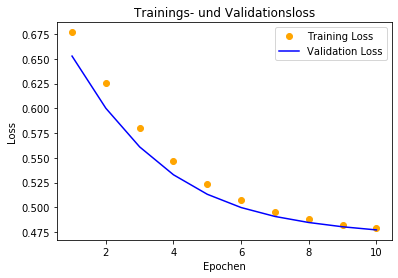

In [22]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'o', color='orange', label='Training Loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'blue', label='Validation Loss')
plt.title('Trainings- und Validationsloss')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.legend()

plt.show()

Das gleiche können wir auch für die Accuracy machen. Hier sollte im Optimalfall die Accuracy mit der Zeit steigen. Dieses Verhalten können wir wieder an unserem Modell erkennen. Hier erinnert der Graph an eine Sättigungskurve. Das liegt daran, dass es mit der Zeit immer schwerer wird das Modell noch mehr zu verbessern, da das Lernen letztendlich eine Optimierung ist, dessen Verbesserung im späteren Verlauf nur mit höheren Aufwänden zu erreichen ist.

An beiden Graphiken kann man jedoch gut erkennen, dass es zu keinem Overfitting kommt. Wenn wir die Accuracy betrachten, würde bei Overfitting die Accuracy der Testdaten weiter Ansteigen, während die Accuracy der Validationsdaten und die der Testdaten stagniert oder gar heruntergeht. Das gleiche würde analog mit dem Loss passieren.

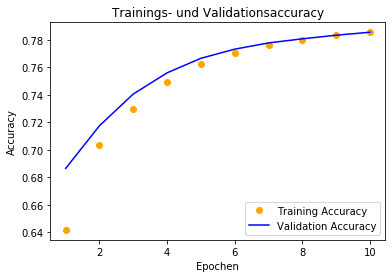

In [23]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'o', color='orange', label='Training Accuracy')
plt.plot(epochs, val_acc, 'blue', label='Validation Accuracy')
plt.title('Trainings- und Validationsaccuracy')
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Nun exportieren wir das fertige Modell. Da wir vorher die Texte vektorisiert haben, bevor sie in das Modell gegeben wurden, können wir hier ein Modell exportieren, welche die Texte beim Input vektorisiert. Dies macht uns jetzt das zukünftige Predicten einfacher. Zusätzlich fügen wir am Ende eine weitere Node mit einer Sigmoid Aktivierungsfunktion hinzu. Diese mappt uns alle Werte zwischen 0 und 1, sodass unsere definiert Sentiment Range eingehalten wird. Die Vektorisationlayer und die Sigmoid Node wurden beim lernen weggelassen, um die Effizienz zu erhöhen.

In [24]:
sentiment_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

Schließlich können wir ein paar Beispiele eingeben um zu sehen, was das Modell denkt. Dabei ist der erste Satz positiv, der zweite neutral und der letzte negativ. Anhand der Ergebnisse können wir sehen, dass das Modell ähnlich darüber denkt. Während der neutrale Satz mit rund 0.5 gewertet wird, wird der positive höher gewertet und der negative geringer.

In [25]:
examples = [
  "Today is a great day!",
  "This sentence is rather neutral",
  "This show is terrible!"
]

sentiment_model.predict(examples)

array([[0.8503943 ],
       [0.5244132 ],
       [0.41561007]], dtype=float32)

## 2. Technisches Modell

Bei dem zweiten Modell soll mithilfe von Finanzdaten eine Progrose erstellt werden, wie der Kursverlauf in den nächsten 30 Tagen sein wird. Für diese Progrose wird ein LSTM-Modell verwendet und die Prognose wird anhand von den Daten von Etherium in US-Dollar aufgebaut. 

### Datenset

Die Daten zum Trainieren des Modelles werden von Yahoo abgefragt. Bei diesen Daten handelt es sich immer um den "Closing Price", also den Preis, den Etherium am Ende eines Tages hatte. Diese Preise werden bis in das Jahr 2015 geladen und in diesem Zeitraum gibt es insgesamt ca. 2000 Preisdaten. Zusätzlich zu den Preisdaten werden mithilfe von der "Technical Analysis Library" verschiedene technische Indikatoren berechnet. Anhand von diesen Indikatoren soll das Modell trainiert werden den Preis vorherzusagen.  

In [295]:
import numpy as np
import pandas_datareader.data as pdr

from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler
import random

from datetime import datetime, timezone,timedelta
from ta.utils import dropna
from ta.volatility import BollingerBands, AverageTrueRange
from ta.momentum import KAMAIndicator, PercentagePriceOscillator, PercentageVolumeOscillator, ROCIndicator, RSIIndicator, StochasticOscillator
from ta.trend import MACD, ADXIndicator, AroonIndicator
from ta.volume import OnBalanceVolumeIndicator, AccDistIndexIndicator

### Laden und generieren der Daten
Im Folgenden werden die Preisdaten von Etherium vom 2015 bis heute geladen. Anschließend werden 7 technische Indikatoren generiert und dem Datensatz hinzugefügt. Zusätzlich werden der Tag des Monats, der Tag der Woche und der Monat als eigene Indikatoren hinzugefügt. Dies ist sinnvoll, da hier ein LSTM-, also ein Zeitreihen-Modell verwendet wird und hierbei auf die Zeit eine sehr wichtige Rolle spielt, um Besonderheiten an beispielsweise dem ersten des Monats erkennen zu können. Außerdem werden die Daten nicht gemischt, da sonst der zeitliche Verlauf verloren geht.

In [296]:
batch_size = 31
symbol = 'ETH-USD'

end = datetime.today()
start = datetime(2000, 9, 1)
ETH = pdr.DataReader(symbol,'yahoo',start,end)

df = pd.DataFrame(data=ETH)

kama_indicator = KAMAIndicator(close = df["Close"], window = 10, pow1 = 2, pow2 = 30, fillna = False)
df['kama'] = kama_indicator.kama()
ppo_indicator = PercentagePriceOscillator(close = df["Close"], window_slow = 20, window_fast = 10, window_sign = 9, fillna = False)
df['ppo'] = ppo_indicator.ppo()
#pvo_indicator = PercentageVolumeOscillator(volume = df["Volume"], window_slow = 20, window_fast = 10, window_sign = 9, fillna = False)
#df['pvo'] = pvo_indicator.pvo()
roc_indicator = ROCIndicator(close = df["Close"], window = 12, fillna = False)
df['roc'] = roc_indicator.roc()
macd_indicator = MACD(close = df["Close"], window_slow = 20, window_fast = 12, window_sign = 9, fillna = False)
df['macd'] = macd_indicator.macd()
rsi_indicator = RSIIndicator(close = df["Close"], window = 14, fillna = False)
df['rsi'] = rsi_indicator.rsi()
#obv_indicator = OnBalanceVolumeIndicator(close = df["Close"], volume = df["Volume"], fillna = False)
#df['obv'] = obv_indicator.on_balance_volume() 
#adi_indicator = AccDistIndexIndicator(high = df["High"], low = df["Low"], close = df["Close"], volume = df["Volume"], fillna = False)
#df['adi'] = adi_indicator.acc_dist_index() 
#adx_indicator = ADXIndicator(high = df["High"], low = df["Low"], close = df["Close"], window = 14, fillna = False)
#df['adx'] = adx_indicator.adx() 
aroon_indicator = AroonIndicator(close = df["Close"], window = 20, fillna = False)
df['aroon'] = aroon_indicator.aroon_indicator()
#stoo_indicator = StochasticOscillator(high = df["High"], low = df["Low"], close = df["Close"], window = 14, smooth_window = 3, fillna = False)
#df['stoo'] = stoo_indicator.stoch()
boll_indicator = BollingerBands(close = df["Close"], window = 20, window_dev = 2, fillna = False)
df['boll_mavg'] = boll_indicator.bollinger_mavg()
#atr_indicator = AverageTrueRange(high = df["High"], low = df["Low"], close = df["Close"], window = 14, fillna = False)
#df['atr'] = atr_indicator.average_true_range()
df.rename(columns = {"Close": "price"}, inplace=True)
prices = df['price'].to_numpy()

df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

increase = []
for i in range(0, len(prices)):
    if(i == len(prices)-1):
        increase.append(1)
    else:
        if(prices[i+1] > prices[i]):
            increase.append(1)
        else:
            increase.append(0)

df['increase'] = increase

df.dropna(inplace=True)
df = df.drop(df.columns[[0, 1, 2, 4, 5]], axis=1)
df

,price,kama,ppo,roc,macd,rsi,aroon,boll_mavg,day_of_month,day_of_week,month,increase
Date,,,,,,,,,,,,
2015-08-25,1.159980,1.405750,-13.445239,-36.539248,-0.166625,35.737493,-10.0,1.340227,25,1,8,0
2015-08-26,1.147700,1.402955,-13.377194,-32.044529,-0.162148,35.483536,25.0,1.259006,26,2,8,1
2015-08-27,1.191380,1.398493,-12.841273,-23.923552,-0.153785,37.193189,25.0,1.280909,27,3,8,0
2015-08-28,1.182550,1.394309,-12.305072,-1.749735,-0.145647,36.979851,20.0,1.304942,28,4,8,1
2015-08-29,1.319270,1.390506,-10.768333,21.362409,-0.129269,42.481178,15.0,1.335483,29,5,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-10,1799.166260,1692.504111,2.072288,24.420770,23.041894,58.146896,-45.0,1659.001465,10,2,3,1
2021-03-11,1826.194946,1705.769443,2.474617,25.084146,28.559460,59.362095,-35.0,1652.302972,11,3,3,0
2021-03-12,1772.102417,1713.443946,2.453372,25.144150,29.194818,55.866143,-35.0,1644.931390,12,4,3,1


Im Folgenden ist nun einmal der gesamt geladene Kursverlauf Etherium zu sehen.

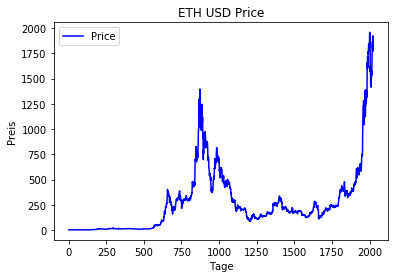

In [297]:
prices = df['price'].to_numpy()
days = range(1, len(prices) + 1)

plt.plot(days, prices, 'blue', label='Price')
plt.title('ETH USD Price')
plt.xlabel('Tage')
plt.ylabel('Preis')
plt.legend()

plt.show()

### Aufteilung in features und labels
Die Daten werden features und labels aufgeteilt. In diesem Fall sind die Spalten, welche in `X_columns` definiert sind, die features und der Preis das label. 

In [298]:
X_columns = ['price', 'kama', 'ppo', 'roc', 'macd', 'rsi', 'aroon', 'boll_mavg', 'increase', 
                   'day_of_month', 'day_of_week', 'month']

X_data = df.filter(X_columns)
y_data = df.filter(['price'])

print(X_data.shape)
print(y_data.shape)

(2024, 12)
(2024, 1)


### Transformation der Daten
Für die Transformation der Daten wird der MinMaxScaler verwendet. Dieser skaliert die Daten in einen vorgegebenen Bereich und macht die Daten damit praktikabel. In diesem Fall werden alle Daten in einem Bereich zwischen 0 und 1 skaliert.

In [299]:
X_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

X_scaled_data = X_scaler.fit_transform(X_data)
y_scaled_data = y_scaler.fit_transform(y_data)

X_scaled_data = pd.DataFrame(data=X_scaled_data, index=X_data.index, columns=X_columns)
y_scaled_data = pd.DataFrame(data=y_scaled_data, index=y_data.index, columns=['price'])

X_scaled_data

,price,kama,ppo,roc,macd,rsi,aroon,boll_mavg,increase,day_of_month,day_of_week,month
Date,,,,,,,,,,,,
2015-08-25,0.000370,0.000470,0.087378,0.076386,0.333396,0.257724,0.447368,0.000432,0.0,0.800000,0.166667,0.636364
2015-08-26,0.000364,0.000469,0.089021,0.097446,0.333423,0.254459,0.631579,0.000387,1.0,0.833333,0.333333,0.636364
2015-08-27,0.000386,0.000466,0.101965,0.135497,0.333472,0.276440,0.631579,0.000399,0.0,0.866667,0.500000,0.636364
2015-08-28,0.000382,0.000464,0.114915,0.239393,0.333520,0.273698,0.605263,0.000412,1.0,0.900000,0.666667,0.636364
2015-08-29,0.000451,0.000462,0.152030,0.347686,0.333617,0.344430,0.578947,0.000430,1.0,0.933333,0.833333,0.636364
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-10,0.917847,0.948974,0.462152,0.362016,0.470348,0.545849,0.263158,0.928977,1.0,0.300000,0.333333,0.181818
2021-03-11,0.931639,0.956415,0.471869,0.365124,0.502906,0.561474,0.315789,0.925225,0.0,0.333333,0.500000,0.181818
2021-03-12,0.904037,0.960719,0.471356,0.365405,0.506655,0.516525,0.315789,0.921095,1.0,0.366667,0.666667,0.181818


Um das Modell trainieren zu können, müssen zunächst die Daten in batches unterteilt werden und danach die batches vermischt werden. 

In [300]:
X_scaled_batches = []
y_scaled_batches = []

for i in range(len(X_scaled_data) - batch_size - 1):
    X_scaled_batches.append(X_scaled_data.iloc[i:(i+batch_size)].values)
    y_scaled_batches.append(y_scaled_data.iloc[i+batch_size + 1])
    
c = list(zip(X_scaled_batches, y_scaled_batches))

random.shuffle(c)

X_random_batches, y_random_batches = zip(*c)

In [301]:
train_size = int(len(X_scaled_batches) * 0.9)
test_size = len(X_scaled_batches) - train_size
X_train_random, X_test_random = X_random_batches[0:train_size], X_random_batches[train_size:len(X_scaled_batches)]
y_train_random, y_test_random = y_random_batches[0:train_size], y_random_batches[train_size:len(y_scaled_batches)]

X_train_random = np.array(X_train_random)
X_train_random = np.reshape(X_train_random, (X_train_random.shape[0], X_train_random.shape[1], X_train_random.shape[2]))
y_train_random = np.array(y_train_random)

X_test_random = np.array(X_test_random)
X_test_random = np.reshape(X_test_random, (X_test_random.shape[0], X_test_random.shape[1], X_test_random.shape[2]))
y_test_random = np.array(y_test_random)

Die gesammelten Daten müssen im nächsten Schritt in Traings- und Testdaten aufgeteilt werden. Dafür wurde die Aufteilung von 90% zu 10% gewählt (90% Traningsdaten und 10% Testdaten).
Beide Datensätze haben immernoch die gleiche Anzahl an Spalten, jedoch sie die Zeilen aufgeteilt worden.

In [302]:
train_size = int(len(X_scaled_batches) * 0.9)
test_size = len(X_scaled_batches) - train_size
X_train, X_test = X_scaled_batches[0:train_size], X_scaled_batches[train_size:len(X_scaled_batches)]
y_train, y_test = y_scaled_batches[0:train_size], y_scaled_batches[train_size:len(y_scaled_batches)]

X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
y_train = np.array(y_train)

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
y_test = np.array(y_test)

### Modell

In [303]:
model = tf.keras.Sequential()

model.add(layers.LSTM(units = 15, return_sequences = False, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units = 1))

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(
    X_train_random, y_train_random,
    epochs=30,
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
51/51 [==============================] - 2s 13ms/step - loss: 0.0580 - val_loss: 0.0038
Epoch 2/30
51/51 [==============================] - 0s 8ms/step - loss: 0.0155 - val_loss: 0.0021
Epoch 3/30
51/51 [==============================] - 0s 7ms/step - loss: 0.0095 - val_loss: 0.0015
Epoch 4/30
51/51 [==============================] - 0s 7ms/step - loss: 0.0059 - val_loss: 0.0011
Epoch 5/30
51/51 [==============================] - 0s 8ms/step - loss: 0.0050 - val_loss: 8.9395e-04
Epoch 6/30
51/51 [==============================] - 0s 8ms/step - loss: 0.0056 - val_loss: 8.9417e-04
Epoch 7/30
51/51 [==============================] - 0s 8ms/step - loss: 0.0045 - val_loss: 8.9142e-04
Epoch 8/30
51/51 [==============================] - 0s 8ms/step - loss: 0.0033 - val_loss: 7.4110e-04
Epoch 9/30
51/51 [==============================] - 0s 8ms/step - loss: 0.0036 - val_loss: 5.6831e-04
Epoch 10/30
51/51 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 5.495

Die loss-Rate sollte bei einem Modell im so gering wie nur möglich sein. In dem folgendem Diagramm ist gut zu sehen, dass die loss-Rate in den ersten Epochen noch relativ hoch war und sich dann immer mehr einer Zahl nahe 0,03 angegelichen hat. Die Rate wurde dann auch ziemlich konstant über die restlichen Epochen gehalten. 

In [304]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

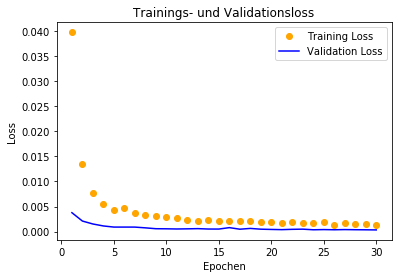

In [305]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'o', color='orange', label='Training Loss')
plt.plot(epochs, val_loss, 'blue', label='Validation Loss')
plt.title('Trainings- und Validationsloss')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Test des Modells
Nachdem das Modell nun trainiert ist, kann mit den Testdaten überprüft werden, wie gut das Modell funktioniert. In dem Diagramm sind 3 Linien eingezeichnet. Die grüne Linie sind die historischen Daten, also die Daten mit dem das Modell trainiert wurde. Die anderen beiden Linien spiegeln den Test wider. Dabei bildet die blaue Linie den tatsächlichen Preisverlauf während der Testphase ab und die rote Linie den vom Modell bestimmten Preisverlauf während der Testphase. 

In [306]:
predicted_price = model.predict(X_train)
predicted_price = y_scaler.inverse_transform(predicted_price)
y_train = y_scaler.inverse_transform(y_train)

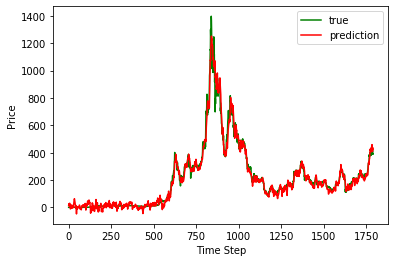

In [307]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="true")
plt.plot(np.arange(0, len(y_train)), predicted_price, 'r', label="prediction")
plt.ylabel('Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

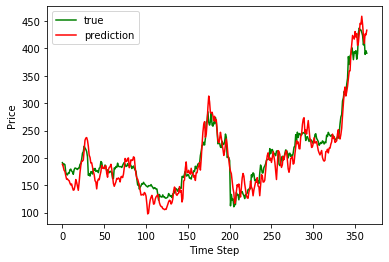

In [308]:
plt.plot(np.arange(0, 365), y_train[-365:], 'g', label="true")
plt.plot(np.arange(0, 365), predicted_price[-365:], 'r', label="prediction")
plt.ylabel('Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Hier sind nochmal die gleichen Zahlen zu sehen, wie in dem Diagramm oben. Es wurden nur die Trainingsdaten weggelassen, um den detailierten Verlauf der beiden anderen Linien zu sehen. 

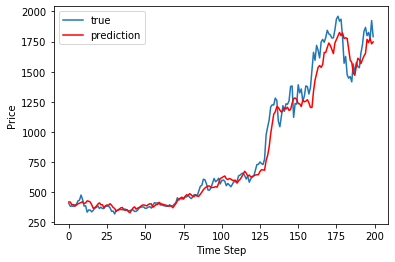

In [309]:
predicted_price = model.predict(X_test)
predicted_price = y_scaler.inverse_transform(predicted_price)
y_train_inv = y_scaler.inverse_transform(y_train)
y_test_inv = y_scaler.inverse_transform(y_test)
predicted_price

plt.plot(y_test_inv, label="true")
plt.plot(predicted_price, 'r', label="prediction")
plt.ylabel('Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Die folgende Funktion dient zur Datenaufbereitung für die Vorhersage des Kursverlaufes 30 Tage in die Zukunft.

In [310]:
def create_data(df):
    kama_indicator = KAMAIndicator(close = df["price"], window = 10, pow1 = 2, pow2 = 30, fillna = False)
    df['kama'] = kama_indicator.kama()
    ppo_indicator = PercentagePriceOscillator(close = df["price"], window_slow = 20, window_fast = 10, window_sign = 9, fillna = False)
    df['ppo'] = ppo_indicator.ppo()
    #pvo_indicator = PercentageVolumeOscillator(volume = df["Volume"], window_slow = 20, window_fast = 10, window_sign = 9, fillna = False)
    #df['pvo'] = pvo_indicator.pvo()
    roc_indicator = ROCIndicator(close = df["price"], window = 12, fillna = False)
    df['roc'] = roc_indicator.roc()
    macd_indicator = MACD(close = df["price"], window_slow = 20, window_fast = 12, window_sign = 9, fillna = False)
    df['macd'] = macd_indicator.macd()
    rsi_indicator = RSIIndicator(close = df["price"], window = 14, fillna = False)
    df['rsi'] = rsi_indicator.rsi()
    #obv_indicator = OnBalanceVolumeIndicator(close = df["Close"], volume = df["Volume"], fillna = False)
    #df['obv'] = obv_indicator.on_balance_volume() 
    #adi_indicator = AccDistIndexIndicator(high = df["High"], low = df["Low"], close = df["Close"], volume = df["Volume"], fillna = False)
    #df['adi'] = adi_indicator.acc_dist_index() 
    #adx_indicator = ADXIndicator(high = df["High"], low = df["Low"], close = df["Close"], window = 14, fillna = False)
    #df['adx'] = adx_indicator.adx() 
    aroon_indicator = AroonIndicator(close = df["price"], window = 20, fillna = False)
    df['aroon'] = aroon_indicator.aroon_indicator()
    #stoo_indicator = StochasticOscillator(high = df["High"], low = df["Low"], close = df["Close"], window = 14, smooth_window = 3, fillna = False)
    #df['stoo'] = stoo_indicator.stoch()
    boll_indicator = BollingerBands(close = df["price"], window = 20, window_dev = 2, fillna = False)
    df['boll_mavg'] = boll_indicator.bollinger_mavg()
    #atr_indicator = AverageTrueRange(high = df["High"], low = df["Low"], close = df["Close"], window = 14, fillna = False)
    #df['atr'] = atr_indicator.average_true_range()
    df['day_of_month'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    prices = df['price'].to_numpy()
    
    increase = []
    for i in range(0, len(df)):
        if(i == len(prices)-1):
            increase.append(1)
        else:
            if(prices[i+1] > prices[i]):
                increase.append(1)
            else:
                increase.append(0)
    df['increase'] = increase

    df_new = df.tail(batch_size)
    predict = df_new.iloc[:len(df_new)]
    

    X_predict = predict.filter(X_columns)
    y_predict = predict.filter(['price'])

    X_scaled_predict = X_scaler.fit_transform(X_predict)
    y_scaled_predict = y_scaler.fit_transform(y_predict)

    X_scaled_predict = pd.DataFrame(data=X_scaled_predict, index=predict.index, columns=X_columns)
    y_scaled_predict = pd.DataFrame(data=y_scaled_predict, index=predict.index, columns=['price'])
    
    return df, X_scaled_predict, y_scaled_predict

### Vorhersage des Kurses 30 Tage in die Zukunft
Für die Vorhersage werden die Daten der letzten 56 Tage abgefragt, anschließend werden wieder alle Indicatoren hinzugefügt. Danach wird der Datensatz wieder auf 30 Einträge gekürzt (wie Batch-Größe) und eine Vorhersage für den nächsten Tag gemacht. Anhand von dem vorhergesagten Preis müssen mit der Funktion oben wieder die verschiedenen Indikatoren berechnet und die Daten in das richtige Format gebracht werden. Danach wird wieder eine Vorhersage für den nächsten Tag gemacht und dies wiederholt sich 30 mal und am Ende ist ein Diagramm mit der Vorhersage für die nächsten 30 Tage zu sehen. 

In [313]:
end = datetime.today()
start = datetime.today() - timedelta(days=batch_size + 50)
ETH = pdr.DataReader(symbol,'yahoo',start,end)

df = pd.DataFrame(data=ETH)
df =  df.drop(df.columns[[0, 1, 2, 4, 5]], axis=1)
df.rename(columns = {"Close": "price"}, inplace=True)
prices = df['price'].to_numpy()

days_in_future = 30
y_predicted_all = []

for i in range(days_in_future):
    df, X_scaled_predict, y_scaled_predict = create_data(df)
    Xs = []
    v = X_scaled_predict.values
    Xs.append(v)
    X = np.array(Xs)
    y_predicted = model.predict(X)
    y_predicted_inv = y_scaler.inverse_transform(y_predicted)
    y_predicted_all.append(y_predicted_inv[0][0])
    del X_scaled_predict
    del y_scaled_predict
    
    add_index = pd.Index([(datetime.today())+ timedelta(days=1)])
    add_index.set_names('Date', inplace=True)
    df2 = pd.DataFrame(index = add_index, data=([[y_predicted_inv[0][0], 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0]]), columns=X_columns)
    df = df.append(df2)
    del y_predicted
    del y_predicted_inv

print(y_predicted_all)

[1757.2203, 1749.3375, 1741.1692, 1734.8379, 1726.2483, 1722.9558, 1729.3927, 1743.2828, 1750.3954, 1765.4246, 1775.26, 1797.3967, 1823.071, 1828.8192, 1829.7954, 1830.6637, 1833.2323, 1810.176, 1800.9523, 1801.9294, 1813.1594, 1822.9492, 1851.9846, 1866.6772, 1879.2775, 1882.7423, 1886.7292, 1889.7238, 1890.3774, 1889.4576]


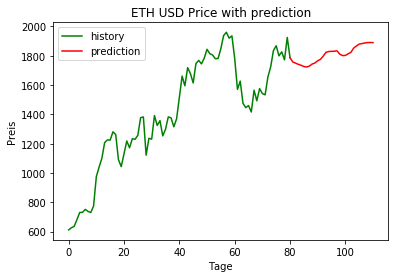

In [314]:
plt.plot(np.arange(0, len(prices)), prices, 'g', label="history")
plt.plot(np.arange(len(prices) - 1, len(prices) + len(y_predicted_all)), [prices[-1]] + y_predicted_all, 'r', label="prediction")
plt.title('ETH USD Price with prediction')
plt.xlabel('Tage')
plt.ylabel('Preis')
plt.legend()

plt.show()

## 3. Auführung

## Anwenden auf Twitter Livedaten

Da die Sentimentanalyse lediglich eine Ergänzung zu der technischen Analyse ist müssen die Ergebnisse entsprechend aufbereitet werden.

Um die Tweets zu fetchen wird `searchtweets` verwendet. Weiterhin wird wieder Matplotlib verwendet, um die Ergebnisse graphisch darzustellen.

In [1]:
# pip install searchtweets-v2
from searchtweets import load_credentials, gen_request_parameters, collect_results
from datetime import datetime
import matplotlib.dates as mdate
import math

Hier laden wir den Token für die Twitter API, dieser sollte sich im Rootordner des Projekts liegen.

In [2]:
search_args = load_credentials("./.twitter_keys.yaml", yaml_key="search_tweets_v2")

Hier definieren wir unsere Queryparameter. Wir laden 100 Tweets, was das Maximum für einen einzelnen API Request ist und geben an, dass alle Tweets mit den Keywords "ether", "eth", "ethereum" oder "cryptocurrency" gefetcht werden sollen. Weiterhin filtern wir Tweets von Bots heraus und Tweets, die das Wort "app" enthalten, da dies meist nur Werbung ist. Zusätzlich müssen die Nutzer verifiziert sein und die Sprache englisch.

In [ ]:
max_tweets = 100

query = gen_request_parameters(
    "(ether OR eth OR ethereum OR cryptocurrency) -bot -app -is:retweet is:verified lang:en",
    tweet_fields="id,created_at,text,public_metrics",
    results_per_call=max_tweets)

Mit `collect_results()` fetchen wir nun die Tweets und reversen sie, da sie hier für uns falschrum ankommen (neuester Tweet kommt hier zuerst). Mit `pop()` entfernen wir das erste Element, da es sich hier um ein Informationsobjekt handelt. Weiterhin filtern wir die für uns relevanten Informationen heraus wie Datum und Text.

In [ ]:
tweets = list(reversed(collect_results(query, max_tweets=max_tweets, result_stream_args=search_args)))

tweets.pop(0)

print(tweets[0])

create_dates = []
tweet_texts = []

for tweet in tweets:
    if 'text' not in tweet:
        continue
    tweet_texts.append(tweet['text'])
    
    utc_time = datetime.strptime(tweet['created_at'], "%Y-%m-%dT%H:%M:%S.%fZ")
    epoch_time = (utc_time - datetime(1970, 1, 1)).total_seconds()
    create_dates.append(epoch_time)

Hier übergeben wir unseren Sentimentmodel den Batch an gefetchten Tweets. Dannach formatieren wir noch das Sentiment, sodass es von -1 bis 1 geht. Somit kann man besser unterscheiden, ob Tweets negativ oder positiv gemeint sind.

In [ ]:
raw_sentiment = sentiment_model.predict(tweet_texts).flatten()

sentiment = []

for s in raw_sentiment:
    sentiment.append((s - 0.5) * 2)

for i in range(5):
    d = create_dates[i]
    t = tweet_texts[i]
    p = sentiment[i]
    print("{} - {} - {}".format(d,t,p))

Da wir den aktuellen Sentimenttrend bestimmen wollen implementieren wir eine Simple Moving Average

In [ ]:
def simple_moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[n:] - cumsum[:-n]) / float(n)

Nun plotten wir das Sentiment in einen Zeitgraphen. Hier können wir bereits erkennen, wir die aktuelle Marktstimmung der letzten Stunden aussieht

In [ ]:
n = 10
sma = simple_moving_avg(sentiment, n)

for i in range(n - 1):
    sma = np.insert(sma, i, sentiment[i])
    
dates = mdate.epoch2num(create_dates)

fig, ax = plt.subplots()

ax.plot(dates, sma, label="simple moving average")
ax.plot(dates, sentiment, "o", label="predicted sentiment")

date_fmt = '%d-%m-%y %H:%M:%S'

date_formatter = mdate.DateFormatter(date_fmt)
ax.xaxis.set_major_formatter(date_formatter)

fig.autofmt_xdate()

plt.title('Predictions and MA')
plt.legend(loc='lower right')

plt.show()

Wir wollen aber zusätzlich noch den Einfluss der Tweets miteinberechnen. Dafür gewichten wir die Tweets mithilfe der Anzahl der Likes. Dafür mulitplizieren wir die Anzahl der Likes mit dem Sentiment Wert (+1 da sonst alle Tweets mit 0 Likes eliminiert werden). Mit den Sigmoid Funktion squashen wir alle Werte zurück in unseren vorherigen Wertebereich.

In [ ]:
weighted_sentiment = []

def normalized_sigmoid(x):
  return ((1 / (1 + math.exp(-x))) - 0.5) * 2

for i in range(len(sentiment)):
    weight = tweets[i]['public_metrics']['like_count'] + 1
    weighted_sentiment.append(normalized_sigmoid(weight * sentiment[i]))


Nun können wir die gewichtete Marktstimmung erneut ausgeben

In [ ]:
n = 10
weighted_sma = simple_moving_avg(weighted_sentiment, n)

for i in range(n - 1):
    weighted_sma = np.insert(weighted_sma, i, weighted_sentiment[i])
    
dates = mdate.epoch2num(create_dates)

fig, ax = plt.subplots()

ax.plot(dates, weighted_sma, label="simple moving average")
ax.plot(dates, weighted_sentiment, "o", label="weighted sentiment")

date_fmt = '%d-%m-%y %H:%M:%S'

date_formatter = mdate.DateFormatter(date_fmt)
ax.xaxis.set_major_formatter(date_formatter)

fig.autofmt_xdate()

plt.title('Weighted predictions and MA')
plt.legend(loc='lower right')

plt.show()

Letztendlich können wir die beiden Werte noch vergleichen, um zu überprüfen, ob die Gewichtung tatsächlich einen Einfluss auf den Stimmungstrend hat

In [ ]:
dates = mdate.epoch2num(create_dates)

fig, ax = plt.subplots()

ax.plot(dates, sma, label="raw", color='blue')
ax.plot(dates, weighted_sma, label="weighted", color='orange')

date_fmt = '%d-%m-%y %H:%M:%S'

date_formatter = mdate.DateFormatter(date_fmt)
ax.xaxis.set_major_formatter(date_formatter)

fig.autofmt_xdate()

plt.title('Raw and weighted predictions')
plt.legend(loc='lower right')

plt.show()